### Imports

In [1]:
import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords
import string
# nltk.download('punkt') # Download the 'punkt' tokenizer
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
import numpy as np
import gensim
import re
import pandas as pd
import os
from tabulate import tabulate
from gensim.models.phrases import Phrases, Phraser
nltk.download('stopwords')
import pickle
import itertools  #used for flattening lists of lists
import math
import csv
from help_functions import test_dictionary
from help_functions import get_next_qtr
import matplotlib.pyplot as plt
from collections import Counter



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Stop Words, CSV Files, and Year List, SNL_Map

In [2]:
nltk_stop_words = set(stopwords.words('english'))
words_to_remove = ['below', 'haven']   #reasonable words to be meaningful
stop_words = list(filter(lambda word: word not in words_to_remove, nltk_stop_words))
print(stop_words)

### create list of csv files and years
csv_files = [os.path.join('data', file) for file in os.listdir('data')]
years_list = list(range(2009, 2025))
print('')
print(csv_files)



### create a look up file to get ciq id and map to related snl id
snl_ciq_map = {}
with open('snldata/SNl_CIQ_MAP.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader) #skips first line
    for row in reader:
        snl_ciq_map[int(row[1][2:])] = int(row[0])

seed_words = ['uncertainty','uncertain','ambiguity', 'confusion', 'unpredictable', 'unpredictability']

### import csv as dataframes for transcript/company ids and loan data/snl ids
delta_df = pd.read_csv('snldata/transcript_loans.csv', encoding='utf-8')
print('')
print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

print('')
print(f'mapping files have been loaded in')

['them', 'each', 'weren', "should've", 'with', 'again', 'has', "hasn't", "couldn't", 'theirs', 'from', 'any', 'that', 'into', 'himself', "shouldn't", 'down', 'doesn', 'is', 'yours', "you're", 'how', 'was', 'does', 'yourself', 'up', "you've", 'and', 'mightn', "she's", "it's", 'll', 'but', 'aren', 'won', 'shan', 'of', 'y', 'then', 'very', 'ain', 'needn', "that'll", 'through', 'those', 'couldn', 'yourselves', 'am', 'wasn', 'themselves', "you'd", 'she', 'after', 'are', 'the', "shan't", 'were', 'why', 'herself', 'now', 'can', 'isn', 'during', 'my', 'wouldn', 'he', 'her', 'having', 'only', "wasn't", "won't", 'did', 'not', 'o', 'hasn', "needn't", 'you', 'ours', 'a', 'to', 'their', 'this', 'no', 'own', 'few', 'nor', 'both', 'because', 'about', 'didn', "mightn't", 've', "hadn't", "wouldn't", 'out', 'don', 'while', 'more', 'ourselves', 'or', 'have', 'in', 'we', 'an', 'do', 'whom', 'its', 'before', 'when', 'will', "weren't", 'me', 't', 'it', 'too', 'd', 'other', 'until', 'at', 'him', 'as', "you'l

In [3]:
with open('snldata/soto_uncertainty_words.txt', 'r') as file:
    # Read each line and strip the newline characters
    soto_uncertainty_words = [line.strip() for line in file.readlines()]

print(soto_uncertainty_words)

['adapted', 'amid', 'amidst', 'amplified', 'anxiety', 'attacks', 'austerity', 'backdrop', 'benign', 'bipartisan', 'brexit', 'ceiling', 'challenges', 'challenging', 'cliff', 'climate', 'clouded', 'commonwealth', 'concerns', 'conditions', 'confluence', 'confronting', 'congress', 'consumption', 'crash', 'crises', 'currents', 'cycles', 'deficit', 'deficits', 'deflation', 'deflationary', 'downturn', 'dysfunction', 'economic', 'election', 'elections', 'emerged', 'encountered', 'environment', 'environments', 'eu', 'euro', 'eurozone', 'face', 'faced', 'faces', 'facing', 'fears', 'fiscal', 'flash', 'fragile', 'franc', 'geo', 'geopolitical', 'governmental', 'governments', 'gridlock', 'gyrations', 'hampering', 'headwinds', 'heightened', 'illiquidity', 'immune', 'impasse', 'instability', 'intervention', 'iraq', 'lackluster', 'legislative', 'legislature', 'lingering', 'looming', 'ltro', 'macroeconomic', 'makers', 'midst', 'midterm', 'monetary', 'myriad', 'nafta', 'navigate', 'navigated', 'navigatin

## Class Definition for Object Storage

In [4]:
class model_bundles:
  bundle_dict = {}

  def __init__(self, year, model, uncertainty_wordlist, corpus_bigrams, bigram_dict, flat_corpus_bigrams):

    self.year = year
    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist
    self.corpus_bigrams = corpus_bigrams
    self.bigram_dict = bigram_dict
    self.flat_corpus_bigrams = flat_corpus_bigrams
    self.idf_dict = create_idf_dict(self)

    model_bundles.bundle_dict[year] = self

class allyr_model:

  def __init__(self, model, uncertainty_wordlist, corpus_bigrams, bigram_dict, flat_corpus_bigrams):

    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist
    self.corpus_bigrams = corpus_bigrams
    self.bigram_dict = bigram_dict
    self.flat_corpus_bigrams = flat_corpus_bigrams
    self.idf_dict = create_idf_dict(self)



## Functions

### Split Text Function

In [5]:
def split_text_to_sentences_words(text):
    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    # Split each sentence into a list of words
    sentences_words = [nltk.word_tokenize(sentence) for sentence in sentences]

    return sentences_words

### Get Corpus, Process Data, and Create Bigrams

In [6]:
#takes single csv file and returns dictionary transcipt_id: [[word, word, word],[word, word, word]]
def get_corpus(csv_file):
   df = pd.read_csv(csv_file, encoding='utf-8')
   df['COMPONENTTEXT_SPLIT'] = df['COMPONENTTEXT'].apply(split_text_to_sentences_words)

   unprocessed_dict = {}
   for row in df.itertuples():
      if row.TRANSCRIPTID not in unprocessed_dict:
         unprocessed_dict[row.TRANSCRIPTID] = row.COMPONENTTEXT_SPLIT
      else:
         unprocessed_dict[row.TRANSCRIPTID].extend(row.COMPONENTTEXT_SPLIT)
   return unprocessed_dict

#takes unprocessed dict and returns processed dict
def process_the_data(unprocessed_dict, stop_words):
   num_tokens_before = 0
   num_tokens_after = 0
   processed_dict = {}

   for transcriptid, text in unprocessed_dict.items():
      p_text = []
      for sentence in text:
         p_sentence = []
         for word in sentence:
            num_tokens_before += 1
            p_word = word.lower()                                  #lowercase the text
            p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)  #remove punctuation but keep hyphens
            if p_word in stop_words or len(p_word) == 0:             #ignore if word has no length (ie was punctuation only) or in stop words
               continue
            p_sentence.append(p_word)
         p_text.append(p_sentence)
         num_tokens_after += len(p_sentence)
      processed_dict[transcriptid] = p_text
   return processed_dict


"""
below function creates:
corpus_bigrams (list of sentences for full corpus to run through word2vec
dict_bigrams: links transcript id to corpus for uncertainty calc
flat_corpus_bigrams: flat version of corpus bigrams for counting word appearances easily
"""

def create_bigrams(processed_dict, min_count=10, threshold = 100):
   processed_corpus = [['']]
   for value in processed_dict.values():
      processed_corpus.extend(value)

   phrases = Phrases(processed_corpus, min_count, threshold, scoring='default')
   bigram_phraser = Phraser(phrases)

   corpus_bigrams = [['']]

   dict_bigrams = {}
   for transcript_id, text in processed_dict.items():
      bigram_text = [bigram_phraser[sentence] for sentence in text]
      dict_bigrams[transcript_id] = bigram_text
      corpus_bigrams.extend(bigram_text)


   flat_corpus_bigrams = [item for sublist in corpus_bigrams for item in sublist]

   # print('bigrams created')
   return phrases, bigram_phraser, corpus_bigrams, dict_bigrams, flat_corpus_bigrams



### Create IDF dictionary

In [25]:
def create_idf_dict(bundle):
    idf_dict = {}
    n = len(bundle.bigram_dict)
    for word in bundle.uncertainty_wordlist:
        t = 0
        for transcript_id, bigrams in bundle.bigram_dict.items():
            transcript_text = list(itertools.chain.from_iterable(bigrams))
            if word in transcript_text:
                t+=1

        idf= math.log2(n/t)
        idf_dict[word] = idf


def create_idf_dict_soto_wordlist(bundle, soto_uncertainty_words):
    idf_dict = {}
    n = len(bundle.bigram_dict)
    for word in soto_uncertainty_words:
        t = 0
        for transcript_id, bigrams in bundle.bigram_dict.items():
            transcript_text = list(itertools.chain.from_iterable(bigrams))
            if word in transcript_text:
                t+=1

        idf= math.log2(n/t)
        idf_dict[word] = idf

    return idf_dict



### Build uncertainty words

In [13]:
def build_uncertainty_words(trained_model, seed_words, return_number = 100):
    result_dictionary = {}
    for seed_word in seed_words:
        try:
            similar_words = trained_model.wv.most_similar(seed_word, topn=500)
        except KeyError:
            continue
        for word, number in similar_words:
            if word not in result_dictionary:
                result_dictionary[word] = number
            else:
                result_dictionary[word] = max(number, result_dictionary[word])

    largest_words = sorted(result_dictionary, key=result_dictionary.get, reverse=True)[:return_number]
    return largest_words


### Calculate Uncertainty scores - regular and soto variant

In [29]:
def calc_uncertainty_reg(bundle, delta_df, column_name):
    for transcript_id, bigrams in bundle.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        uncty_cnt = 0
        for word in transcript_text:
            if word in bundle.uncertainty_wordlist:
                uncty_cnt += 1
        uncty_score = uncty_cnt/len(transcript_text)
        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
        except KeyError:
            continue

def calc_uncertainty_soto(bundle, delta_df, column_name):
    for transcript_id, bigrams in bundle.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        word_count_dict = Counter(transcript_text)
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in bundle.uncertainty_wordlist:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = bundle.idf_dict[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue


def calc_uncertainty_soto_wordlist(bundle, delta_df, column_name, soto_uncertainty_words):
    for transcript_id, bigrams in bundle.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        word_count_dict = Counter(transcript_text)
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in soto_uncertainty_words:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = bundle.idf_dict_full[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue



### Extend yearly corpus to full corpus

In [10]:
def extend_to_full(model_bundle_dict):
    corpus_bigrams_allyrs = []
    flat_corpus_allyrs = []
    bigram_dict_allyrs = {}

    for year, bundle in model_bundle_dict.items():
        corpus_bigrams_allyrs.extend(bundle.corpus_bigrams)
        flat_corpus_allyrs.extend(bundle.flat_corpus_bigrams)
        bigram_dict_allyrs.update(bundle.bigram_dict)

    return corpus_bigrams_allyrs,flat_corpus_allyrs,bigram_dict_allyrs


### Word2Vec Model

In [11]:

def apply_word2vec(corpus_bigrams):
   model = gensim.models.Word2Vec (
    vector_size=150,    # Number of features in word vector

    window=10,   # Context window size (in each direction). Default is 5


    min_count=5, # Words must appear this many times to be in vocab.
                 #   Default is 5

    workers=10,  # Training thread count

    sg=1,        # 0: CBOW, 1: Skip-gram.

    hs=0,        # 0: Negative Sampling, 1: Hierarchical Softmax
                 #   Default is 0, NS

    negative=5   # Nmber of negative samples
                 #   Default is 5
   )

   model.build_vocab(
    corpus_bigrams,
    progress_per=20000  # Tweaks how often progress is reported
   )

   model.train(
    corpus_bigrams,
    total_examples=len(corpus_bigrams),
    epochs=10,        # How many training passes to take.
    report_delay=10.0 # Report progress every 10 seconds.
   )

   return(model)

## Run Models

In [14]:
for index, file in enumerate(csv_files):
    corpus_dict = get_corpus(file)
    processed_corpus_dict = process_the_data(corpus_dict, stop_words)
    phrases, bigram_phraser, corpus_bigrams, bigram_dict, flat_corpus_bigrams = create_bigrams(processed_corpus_dict)
    trained_model = apply_word2vec(corpus_bigrams)

    word_list = build_uncertainty_words(trained_model, seed_words, 100)

    model_bundles(year=years_list[index], model=trained_model, uncertainty_wordlist=word_list,
               corpus_bigrams=corpus_bigrams, bigram_dict=bigram_dict, flat_corpus_bigrams = flat_corpus_bigrams)




print('done!!')

done!!


In [15]:
corpus_bigrams_allyrs,flat_corpus_allyrs,bigram_dict_allyrs = extend_to_full(model_bundles.bundle_dict)
trained_model = apply_word2vec(corpus_bigrams_allyrs)
word_list = build_uncertainty_words(trained_model, seed_words, 150)

full_model = allyr_model(model=trained_model, uncertainty_wordlist=word_list,
               corpus_bigrams=corpus_bigrams_allyrs, bigram_dict = bigram_dict_allyrs, flat_corpus_bigrams = flat_corpus_allyrs)

print('done!!')

done!!


In [27]:
idf_dict_full = create_idf_dict_soto_wordlist(full_model, soto_uncertainty_words)
full_model.idf_dict_full = idf_dict_full

## Calc Uncertainty Scores

In [30]:
for year, bundle in model_bundles.bundle_dict.items():
    calc_uncertainty_reg(bundle, delta_df, 'year_uncertainty_score_reg')


calc_uncertainty_reg(full_model, delta_df, 'full_uncertainty_score_reg')

for year, bundle in model_bundles.bundle_dict.items():
    calc_uncertainty_soto(bundle, delta_df, 'year_uncertainty_score_soto')


calc_uncertainty_soto(full_model, delta_df, 'full_uncertainty_score_soto')

calc_uncertainty_soto_wordlist(full_model, delta_df, 'full_uncertainty_score_soto_wordlist', soto_uncertainty_words)

In [35]:
print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

+---+---------------+----------+---------+---------+------+--------------------+-------------------+-------------+------------+--------------------+-----------+----------------------------+----------------------------+-----------------------------+-----------------------------+--------------------------------------+
|   | transcript_id |  ciq_id  | snl_id  | quarter | year | total_asset_before | total_asset_after | loan_before | loan_after |     l2a_delta      | loan_diff | year_uncertainty_score_reg | full_uncertainty_score_reg | year_uncertainty_score_soto | full_uncertainty_score_soto | full_uncertainty_score_soto_wordlist |
+---+---------------+----------+---------+---------+------+--------------------+-------------------+-------------+------------+--------------------+-----------+----------------------------+----------------------------+-----------------------------+-----------------------------+--------------------------------------+
| 0 |    1790209    | 13314302 | 4055785 | Q4 

## Get Word Lists

In [31]:
combined_uncertainty_wordlist = []

for year in years_list:
    for uncertainty_word in model_bundles.bundle_dict[year].uncertainty_wordlist:
        if uncertainty_word not in combined_uncertainty_wordlist:
            combined_uncertainty_wordlist.append(uncertainty_word)

print(len(combined_uncertainty_wordlist))

1214


In [32]:
word_freq_df = pd.DataFrame(index=years_list, columns=combined_uncertainty_wordlist)

In [33]:
## count total instances of word
for year in years_list:
    word_counts = Counter((model_bundles.bundle_dict[year].flat_corpus_bigrams))
    for uncertainty_word in combined_uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        word_freq_df.at[year, uncertainty_word] = count

In [34]:
for year in years_list:
    print(year)
    for word in model_bundles.bundle_dict[year].uncertainty_wordlist:
        average_count = word_freq_df[word].mean()
        year_count = word_freq_df.at[year, word]

        if year_count/average_count > 3:
            print(f"{word} | {year_count} / {average_count}")
    print()
    print('---')

2009
malaise | 7 / 1.875
plaguing | 5 / 0.625
mid-west | 6 / 0.875
eminent | 6 / 1.6875
economic_climate | 37 / 5.3125
turndown | 5 / 1.5
categorically | 7 / 1.375
troubling | 9 / 2.5625
dysfunctional | 5 / 1.0
strained | 13 / 2.5625

---
2010
strategies_inherently | 12 / 1.5
interpretations | 6 / 1.5625
fragile | 22 / 5.875
pre-emption | 5 / 0.375
rule-making | 6 / 1.0
monolines | 15 / 4.3125

---
2011
generalities | 5 / 0.875
annoying | 5 / 1.5625
regulatorily | 5 / 1.4375
double-dip | 12 / 1.75
debt_ceiling | 14 / 2.375
manifestation | 9 / 1.6875
pre-payments | 18 / 3.75
eta | 7 / 0.8125
stigma | 6 / 1.375
fragile | 25 / 5.875
irregular | 8 / 2.0625
unintelligible | 5 / 0.375

---
2012
flipside | 6 / 1.75
generalizations | 6 / 0.625
ecb | 6 / 1.1875
election_fiscal | 17 / 1.0625
fools | 6 / 0.625
parade | 5 / 1.125
fiscal_cliff | 87 / 9.375
generalization | 5 / 1.5625
monolines | 15 / 4.3125
conor | 8 / 0.625
giants | 5 / 1.25
lackluster | 9 / 2.375
ags | 5 / 1.3125
cuff | 5 / 0.875

In [39]:
word_counts = Counter(full_model.flat_corpus_bigrams)
for uncertainty_word in full_model.uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        print(f"{uncertainty_word} | {count}")


geopolitical | 311
choppy | 315
uncertain | 1760
uncertainty | 5158
geopolitical_tensions | 12
unpredictability | 35
circumstantial | 8
tamper | 6
unknowns | 190
flaws | 13
war_ukraine | 35
fragile | 94
unknown | 547
strategies_inherently | 24
setters | 8
volatile | 2081
certainty | 657
uncertainty_surrounding | 47
hard_predict | 1178
gridlock | 14
economic | 19258
unpredictable | 260
pinning | 5
concerns | 1938
challenging | 5302
difficult_predict | 924
fate | 9
trade_wars | 12
debt_ceiling | 38
trepidation | 25
revelatory | 5
macro | 2336
swirling | 10
stalling | 15
optimism | 1554
tensions | 38
uneven | 274
volatility | 5665
paralysis | 13
cautious | 3469
tension | 64
imposes | 9
real-world | 12
uncertainly | 10
cramdown | 7
anxiety | 64
infectious | 6
adjudicated | 5
cease-and-desist | 8
unrest | 65
microeconomic | 12
procedurally | 6
alerted | 11
rapidly_evolving | 12
murky | 36
watchword | 6
mercy | 22
lumpy | 1632
roadblock | 9
posturing | 20
voluminous | 5
rulings | 14
data-dep

In [42]:
common_words = set(soto_uncertainty_words) & set(full_model.uncertainty_wordlist)
for word in common_words:
    print(word)
print('-----')
print('Just in soto')
print('-----')
difference_list1 = list(set(soto_uncertainty_words) - set(full_model.uncertainty_wordlist))
for word in difference_list1:
    print(word)
print('-----')
print('Just in mine')
print('-----')
difference_list2 = list(set(full_model.uncertainty_wordlist) - set(soto_uncertainty_words))
for word in difference_list2:
    print(word)


concerns
navigate
economic
tensions
unrest
uncertain
rhetoric
instability
fragile
dysfunction
deflationary
gridlock
uncertainty
paralysis
political
challenging
unsettled
anxiety
uneven
unstable
geopolitical
-----
Just in soto
-----
turmoil
bipartisan
psychology
deflation
midst
persistently
amid
withstand
deficit
spite
fears
rican
threat
franc
impasse
nafta
election
illiquidity
benign
unprecedented
governmental
fiscal
sars
emerged
crash
lingering
governments
stressful
prolonged
legislative
peso
climate
tariffs
sequester
stimulative
tsunami
backdrop
ripple
looming
challenges
attacks
society
midterm
environments
facing
unfolded
eu
flash
reactions
persist
weathering
heightened
reforms
ceiling
sparked
amidst
environment
protracted
upheaval
euro
monetary
turbulent
faces
lackluster
navigated
headwinds
conditions
currents
deficits
cliff
myriad
prevailing
confluence
presidential
face
makers
swiss
legislature
iraq
realities
war
encountered
persistent
tariff
congress
macroeconomic
immune
terroris

In [ ]:
index = model_year.years[2024].flat_corpus_bigrams.index('qt')
print(index)
start = max(0, index - 10)
end = min(len(word_list), index + 11)

print(model_year.years[2024].flat_corpus_bigrams[index - 10:index + 10])

In [30]:
for word in tfidf_df.columns:
    for year in years_list:
        idf = idf_scores[word]

        doc_length = len(model_year.years[year].uncertainty_wordlist)
        count = 0

        for checked_word in model_year.years[year].uncertainty_wordlist:
            if word == checked_word:
                count+=1

        tf = count/doc_length
        tf_idf = tf * idf

        tfidf_df.at[year, word] = tf_idf







In [ ]:
print(tfidf_df.head())

In [ ]:
# def top_10_columns_by_row(row):
#     # Sort values in descending order and get top 10 columns
#     return row.nlargest(10).index.tolist()

# df['top_10_columns'] = tfidf_df.apply(top_10_columns_by_row, axis=1)
# print(df[['top_10_columns']])

for index, row in tfidf_df.iterrows():
    # Sort row values in descending order and print top 10 with column names
    print(f"Row {index}:")
    sorted_row = row.sort_values(ascending=False)

    # Print column names and values for the top 10 items
    for col, value in sorted_row.head(20).items():
        print(f"{col}, Value: {value}")

In [ ]:
print(model_year.years[2010].corpus_bigrams[1:5])
print(len(model_year.years[2010].corpus_bigrams))

In [ ]:
scores = {}

for year, model in model_year.years.items():
    score_list = [0] * len(model.uncertainty_wordlist)  #create dummy holder for frequency scores

    for index, word in enumerate(model.uncertainty_wordlist):
        count = 0
        for model in model_year.years.values():
            if word in model.uncertainty_wordlist:
                count += 1
        score_list[index] = count
    scores[year] = score_list


In [ ]:
for year, score_list in scores.items():
    print(year)
    for index, score in enumerate(score_list):
        if score < 2:
            print(f'{model_year.years[year].uncertainty_wordlist[index]} : {score}')
    print()
    print()

In [ ]:
similar_words = trained_model.wv.most_similar('uncertainty', topn=100)
word_list = [word for word, number in similar_words]

# Print the most similar words and their similarity scores
for word, similarity in similar_words:
    print(f"{word}: Similarity = {similarity:.4f}")

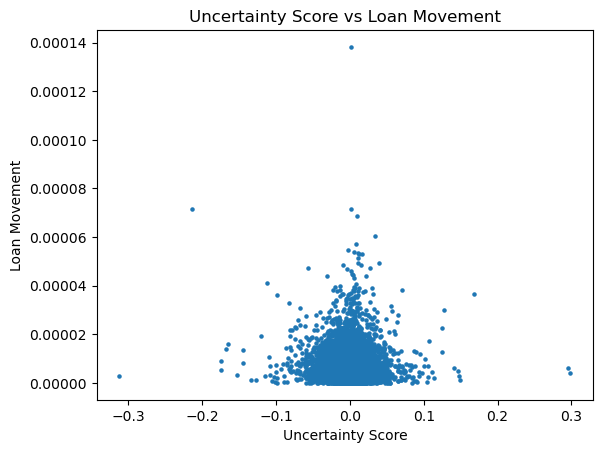

Correlation between Uncertainty Score and Loan Movement: -0.04296080526805658


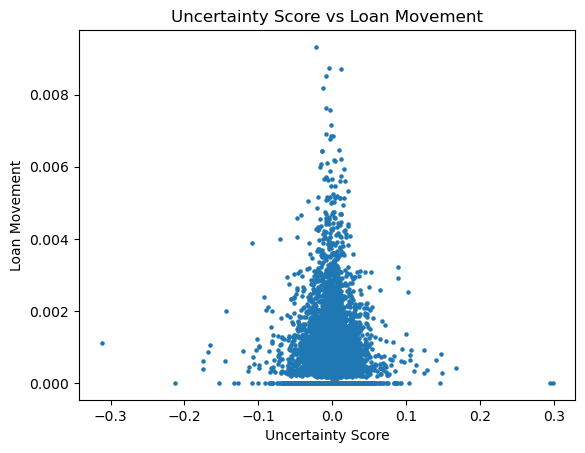

Correlation between Uncertainty Score and Loan Movement: -0.050067259303238104


In [37]:


# Scatter plot of uncertainty score vs loan movement
plt.scatter(delta_df['l2a_delta'], delta_df['full_uncertainty_score_soto_wordlist'], s=5)
plt.xlabel('Uncertainty Score')
plt.ylabel('Loan Movement')
plt.title('Uncertainty Score vs Loan Movement')
plt.show()

correlation = delta_df['full_uncertainty_score_soto_wordlist'].corr(delta_df['l2a_delta'])
print(f"Correlation between Uncertainty Score and Loan Movement: {correlation}")

plt.scatter(delta_df['l2a_delta'], delta_df['year_uncertainty_score_reg'], s=5)
plt.xlabel('Uncertainty Score')
plt.ylabel('Loan Movement')
plt.title('Uncertainty Score vs Loan Movement')
plt.show()

correlation = delta_df['year_uncertainty_score_reg'].corr(delta_df['l2a_delta'])
print(f"Correlation between Uncertainty Score and Loan Movement: {correlation}")

In [ ]:
plt.scatter(delta_df['loan_diff'], delta_df['full_uncertainty_score_soto'], s=5)
plt.ylabel('Uncertainty Score')
plt.xlabel('Loan Movement')
plt.title('Uncertainty Score vs Loan Movement')
plt.show()

correlation = delta_df['full_uncertainty_score_soto'].corr(delta_df['loan_diff'])
print(f"Correlation between Uncertainty Score and Loan Movement: {correlation}")

plt.scatter(delta_df['loan_diff'], delta_df['year_uncertainty_score_soto'], s=5)
plt.ylabel('Uncertainty Score')
plt.xlabel('Loan Movement')
plt.title('Uncertainty Score vs Loan Movement')
plt.show()

correlation = delta_df['year_uncertainty_score_soto'].corr(delta_df['loan_diff'])
print(f"Correlation between Uncertainty Score and Loan Movement: {correlation}")

In [ ]:
negative_count = (delta_df['loan_diff'] < 0).sum()
total = len(delta_df)

print(negative_count)
print(negative_count/total)